# Step_3a_Data_level_approach_Oversampling

**In this notebook we will apply simple classification models after oversampling the minority class**

As we conclude in the notebook :metrics, we will use the roc-auc metric to evaluate the performance of the models and we will analyze the false negative ratio which is what we are interested in minimizing.

# CONTENT

    1. Import Libraries
    2. Load data
    3. Undersampling methods
    4. Modeling
        4.1 Logistic Regression
        4.2 k-Nearest Neighbors
        4.3 Decision Trees
        4.4 Support Vector Machine
        4.5 Random Forest
    5. Summary and conclusions

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np


#show cells with width as long as screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
#Hide warnings
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.options.display.max_columns = None

#Oversampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN,\
BorderlineSMOTE, SVMSMOTE

#Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    BaggingClassifier,
    AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
)

#metric
from sklearn.metrics import roc_auc_score, plot_roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# 2. Load data

This data has been generated in the notebook: step_2_Preprocessing_data

In [2]:
X_train = pd.read_excel('X_train_step_2.xlsx', engine='openpyxl')
X_test =  pd.read_excel('X_test_step_2.xlsx', engine='openpyxl')
y_train = pd.read_excel('y_train_step_2.xlsx', engine='openpyxl')
y_test = pd.read_excel('y_test_step_2.xlsx', engine='openpyxl')

# 3. Oversampling methods

In order to use the different oversampling techniques we group it in a dictionary (To understand how each technique works you can go to the notebook: step_2 where the final size and distribution after applying the different techniques are shown)

In [3]:
oversampler_dict = {
    'random' : RandomOverSampler(
        sampling_strategy='auto', 
        random_state=0),
    
    'smote' : SMOTE(
        sampling_strategy='all', 
        random_state=0,
        k_neighbors=3,
        n_jobs = 4),
    
    'adasyn' : ADASYN(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=3,
    n_jobs=4),
    
    'border1' : BorderlineSMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=3,
    m_neighbors=5,
    kind='borderline-1',
    n_jobs=4),
    
    'border2' : BorderlineSMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=3,
    m_neighbors=5,
    kind='borderline-2',
    n_jobs=4),
    
    'svm' : SVMSMOTE(
        sampling_strategy='auto',
        random_state=0,
        k_neighbors=3,
        m_neighbors=5,
        n_jobs=-1,
        svm_estimator=SVC(kernel='linear')),
}

# 4. Classification models

Although it can be done in several ways, we will create a function for each model and then apply them to the different oversampling techniques.

**NOTE:**

I have found that by applying any model I get overfitting. Overfitting occurs when a model adjusts excessively to the training data, seeing patterns that do not exist, and consequently performing poorly in predicting new data: he fewer samples for training, the more models can fit our data.In order to solve the overfitting problem I have tried to simplify and reduce the flexibility of  the hyperparameters of the machine leraning model, apply regularization parameters. 

 On the other hand I have observed that using cross-validation technique induce more overfitting(paper)

However I have not been able to solve it. So it should also be noted that the overfitting can be also generated by de small dataset size, depending how separate is the minority class with respect the majority class and the presence of noisy boundaries or Within-class sub-clusters

## 4.1 Logistic Regression

In a first attempt we make a gridsearch of several hyperparameters of the model in order to find the best performance of the model.

In [4]:

def run_LogisticRegression_1(X_train, X_test, y_train, y_test):
    
    '''This function applies the logistic regression model with a cross validation searching for optimal hyperparameters through cross-validation.
    it prints the best score and best parameters and it uses the best parameters to fit the model.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
    
    model = LogisticRegression(max_iter=100)
    
    #define values for tuning
    solvers = ['newton-cg', 'lbfgs', 'liblinear']
    penalty = ['l2']
    c_values = [100, 10, 1.0, 0.1, 0.01]
    
    # define grid search
    grid = dict(solver=solvers,penalty=penalty,C=c_values) 
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=3, scoring='roc_auc') #ccv = 3-fold cross validation, n_jobs = run in parallel
    grid_result = grid_search.fit(X_train, y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    
    #model prediction
    print('Train set')
    pred = grid_result.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_result.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_result.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_result.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR

We make a loop to test all oversampling methods in the model. We store the results of test_roc-auc value, FNR, FNP and size in a dictionary for each variable.

In [5]:
results_dict_LG1 = {}
shapes_dict_LG1  = {}
conf_matrix_LG1  = {}
FNR_dict_LG1  = {}
FPR_dict_LG1  = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_LogisticRegression_1(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_LG1 [oversampler] = roc[0]
    conf_matrix_LG1 [oversampler] = roc[1]
    FPR_dict_LG1 [oversampler] = roc[2]
    FNR_dict_LG1 [oversampler] = roc[3]
    shapes_dict_LG1 [oversampler] = len(X_resampled)  
    print()
    
print()

random
Best: 0.602036 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Train set
Logistic Regression roc-auc: 0.8255568771626298
Test set
Logistic Regression roc-auc: 0.5644796380090498

smote
Best: 0.885636 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Train set
Logistic Regression roc-auc: 0.9546253243944637
Test set
Logistic Regression roc-auc: 0.5271493212669683

adasyn
Best: 0.869340 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Train set
Logistic Regression roc-auc: 0.9566232386490717
Test set
Logistic Regression roc-auc: 0.5407239819004526

border1
Best: 0.880885 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Train set
Logistic Regression roc-auc: 0.9568149870242214
Test set
Logistic Regression roc-auc: 0.5294117647058824

border2
Best: 0.867521 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Train set
Logistic Regression roc-auc: 0.9597487518992837
Test set
Logistic Regression roc-auc: 0.5395927601809956

svm
Best: 0.797899 using

Comparing the train_set and test_set we observe that we have a huge overfitting since the roc-auc values at training_set is around 90% and the test_set is around 50%

### **Summary of results**

a) summary of all roc-auc scores dependeng of sampling method

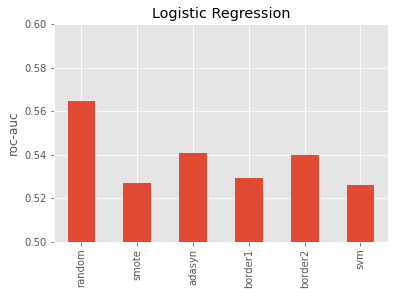

In [6]:
pd.Series(results_dict_LG1).plot.bar()
plt.title('Logistic Regression')
plt.ylabel('roc-auc')
plt.ylim(0.5, 0.6)
plt.show();

Fuerthermore the model's performance for all oversampling techniques is not good. Remember that roc_auc_score ranges between 1(perfect model)-0.5(random model)

b) Confusion matrix

In [7]:
pd.DataFrame([[key, conf_matrix_LG1[key]] for key in conf_matrix_LG1.keys()], columns=['Name', 'Amount'])

,Name,Amount
0,random,"[[43, 25], [9, 4]]"
1,smote,"[[67, 1], [10, 3]]"
2,adasyn,"[[68, 0], [12, 1]]"
3,border1,"[[68, 0], [10, 3]]"
4,border2,"[[68, 0], [12, 1]]"
5,svm,"[[62, 6], [10, 3]]"


In [8]:
conf_matrix_LG1 

{'random': array([[43, 25],
        [ 9,  4]], dtype=int64),
 'smote': array([[67,  1],
        [10,  3]], dtype=int64),
 'adasyn': array([[68,  0],
        [12,  1]], dtype=int64),
 'border1': array([[68,  0],
        [10,  3]], dtype=int64),
 'border2': array([[68,  0],
        [12,  1]], dtype=int64),
 'svm': array([[62,  6],
        [10,  3]], dtype=int64)}

c) False Negative Rate

In [9]:
pd.DataFrame([[key, FNR_dict_LG1[key]] for key in FNR_dict_LG1 .keys()], columns=['oversampling', 'FNR'])

,oversampling,FNR
0,random,0.692308
1,smote,0.769231
2,adasyn,0.923077
3,border1,0.769231
4,border2,0.923077
5,svm,0.769231


The FNR values, which for our case is the one we want to minimize, because we want to avoid false negatives in order to treat the patient, have very high values (remember that it varies from 1 (all are FN) to 0 (there are no FN)).

In [10]:
FNR_dict_LG1.values()

dict_values([0.6923076923076923, 0.7692307692307693, 0.9230769230769231, 0.7692307692307693, 0.9230769230769231, 0.7692307692307693])

In order to solve the overfitting problem the strategy is to simplify the model since the overfitting is occurring because the algorithm has too much flexibility and learns too much from noise or features that do not correspond to the generality and as a consequence the training model can't correctly predict new data that has never been presented to the model

In this model, we can control the regularization by means of the penalty and C parameters (inverse of regularization strength - smaller values specify stronger regularization) to deal with the overfitting:
The idea of regularization is to introduce additional information (bias) to penalize extreme parameter weights

Avoid complex models with many parameters, thus limiting their generalization and possibility of overfitting. Regularization techniques like L1 and L2 also help make the models more conservative. For tree-based models, reducing their maximum depth also limits the model's ability to see patterns and non-existent relationships

In [15]:
def run_LogisticRegression_2(X_train, X_test, y_train, y_test):
    
    '''This function applies the logistic regression model with more conservative parameters.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
        
    
    model = LogisticRegression(
    random_state=42,
    penalty='l1',
    C=0.1,
    max_iter=10000,
    solver = 'saga')
    
    model.fit(X_train, y_train)

    print('Train set')
    pred = model.predict_proba(X_train)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = model.predict_proba(X_test)
    print('Logistic Regression roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, model.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    

    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR

In [16]:
results_dict_LG2 = {}
shapes_dict_LG2  = {}
conf_matrix_LG2  = {}
FNR_dict_LG2  = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_LogisticRegression_2(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_LG2 [oversampler] = roc[0]
    conf_matrix_LG2 [oversampler] = roc[1]
    FNR_dict_LG2 [oversampler] = roc[3]
    shapes_dict_LG2 [oversampler] = len(X_resampled)  
    print()
    
print()

random
Train set
Logistic Regression roc-auc: 0.7389841046712802
Test set
Logistic Regression roc-auc: 0.6527149321266968

smote
Train set
Logistic Regression roc-auc: 0.8288684039792387
Test set
Logistic Regression roc-auc: 0.6176470588235294

adasyn
Train set
Logistic Regression roc-auc: 0.8200206888839185
Test set
Logistic Regression roc-auc: 0.5825791855203619

border1
Train set
Logistic Regression roc-auc: 0.8474940527681661
Test set
Logistic Regression roc-auc: 0.581447963800905

border2
Train set
Logistic Regression roc-auc: 0.8528597785977861
Test set
Logistic Regression roc-auc: 0.5656108597285069

svm
Train set
Logistic Regression roc-auc: 0.8397288602941178
Test set
Logistic Regression roc-auc: 0.5712669683257918




As a result we have been able to decrease overfitting and we have also obtained better model performance.

### Summary of results

a) summary of all roc-auc scores dependeng of sampling method

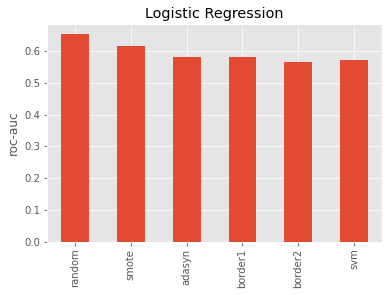

In [17]:
pd.Series(results_dict_LG2).plot.bar()
plt.title('Logistic Regression')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [18]:
conf_matrix_LG2

{'random': array([[46, 22],
        [ 4,  9]], dtype=int64),
 'smote': array([[46, 22],
        [ 6,  7]], dtype=int64),
 'adasyn': array([[47, 21],
        [ 8,  5]], dtype=int64),
 'border1': array([[40, 28],
        [ 5,  8]], dtype=int64),
 'border2': array([[45, 23],
        [ 7,  6]], dtype=int64),
 'svm': array([[48, 20],
        [ 8,  5]], dtype=int64)}

Compared to the previous model, this more conservative model is able to classify more positive classes for all oversampling techniques.

c) False Negative Rate

In [19]:
FNR_dict_LG2

{'random': 0.3076923076923077,
 'smote': 0.46153846153846156,
 'adasyn': 0.6153846153846154,
 'border1': 0.38461538461538464,
 'border2': 0.5384615384615384,
 'svm': 0.6153846153846154}

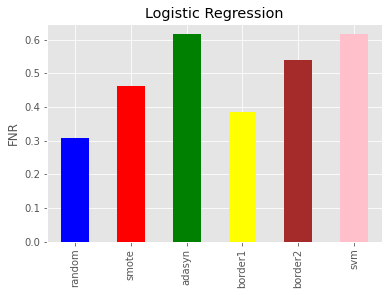

In [20]:
#plot_FNR
pd.Series(FNR_dict_LG2).plot.bar(color=['blue','red','green','yellow','brown', 'pink'], edgecolor='none')
plt.title('Logistic Regression')
plt.ylabel('FNR')

plt.show();

As a consequence of having a higher number of TPs, we see that we are able to minimize considerably the FNR for random and adassyn techniques

**Conclusion**: 
More logistic regression models have been tested by varying the penalty parameters and the parameter C. However, no better results have been obtained, so we will try other classification models.


## 4.2 k-Nearest Neighbors

In [21]:
def run_KNN_1(X_train, X_test, y_train, y_test):
    
    '''This function applies k-Nearest Neighbors model.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR) '''
    
   
    
    grid_search_clf_gk = KNeighborsClassifier(n_neighbors=7, p=1, metric='minkowski' ) #When p = 1, this is equivalent to using manhattan_distance
 

    #grid_search_clf_gk = GridSearchCV(clf_gk, param_grid, cv = 3, n_jobs = -1, scoring='roc_auc', ) Overfitting
    grid_search_clf_gk.fit(X_train, y_train)
    
  
    
    print('Train set')
    pred = grid_search_clf_gk.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_clf_gk.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_clf_gk.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
     
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 


In [22]:
results_dict_KNN = {}
shapes_dict_KNN = {}
conf_matrix_KNN = {}
FNR_dict_KNN = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_KNN_1(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_KNN[oversampler] = roc[0]
    conf_matrix_KNN[oversampler]= roc[1]
    FNR_dict_KNN[oversampler]= roc[3]
    shapes_dict_KNN[oversampler]= len(X_resampled)  
    print()
    
print()

random
Train set
Decision Tree: 0.9730617430795847
Test set
Decision Tree: 0.7222850678733032

smote
Train set
Decision Tree: 0.9879027897923875
Test set
Decision Tree: 0.6923076923076923

adasyn
Train set
Decision Tree: 0.9918502572131515
Test set
Decision Tree: 0.6832579185520362

border1
Train set
Decision Tree: 0.9831247296712803
Test set
Decision Tree: 0.7222850678733033

border2
Train set
Decision Tree: 0.9842155958324289
Test set
Decision Tree: 0.7358597285067873

svm
Train set
Decision Tree: 0.9831450043252594
Test set
Decision Tree: 0.7070135746606335




### **Summary of results**

a)summary of all roc-auc scores dependeng of sampling method

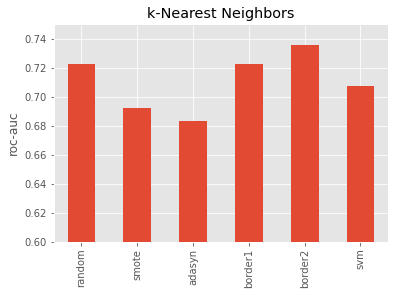

In [23]:
pd.Series(results_dict_KNN).plot.bar()
plt.title('k-Nearest Neighbors')
plt.ylabel('roc-auc')
plt.ylim(0.6, 0.75)

plt.show();

Despite still having overfitting, this model performs better than the logistic regression model.

b) Confusion Matrix

In [24]:
conf_matrix_KNN

{'random': array([[44, 24],
        [ 4,  9]], dtype=int64),
 'smote': array([[40, 28],
        [ 4,  9]], dtype=int64),
 'adasyn': array([[40, 28],
        [ 4,  9]], dtype=int64),
 'border1': array([[40, 28],
        [ 3, 10]], dtype=int64),
 'border2': array([[44, 24],
        [ 4,  9]], dtype=int64),
 'svm': array([[45, 23],
        [ 6,  7]], dtype=int64)}

c) False Negative Rate

In [25]:
FNR_dict_KNN

{'random': 0.3076923076923077,
 'smote': 0.3076923076923077,
 'adasyn': 0.3076923076923077,
 'border1': 0.23076923076923078,
 'border2': 0.3076923076923077,
 'svm': 0.46153846153846156}

It is important to note that in addition to the better performance of the model, the value of FNR also decreases

**Searching for optimal K value**

In theory it is more reliable to do a gridsearch to obtain the optimal value, but I want to avoid cross validations dur to overfitting issues.

For simplicity, taking into account that after the oversampling process we have the same initial distribution, we will calculate the optimal value of K for the data without sampling.

In [26]:
#det K number representing error rate vs k values
error_rate=[]

for i in range(1,40):
    knn =KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train.values, y_train.values)
    pred_i = knn.predict(X_test.values)
    error_rate.append(np.mean(pred_i != y_test.values))

Text(0, 0.5, 'Mean Error')

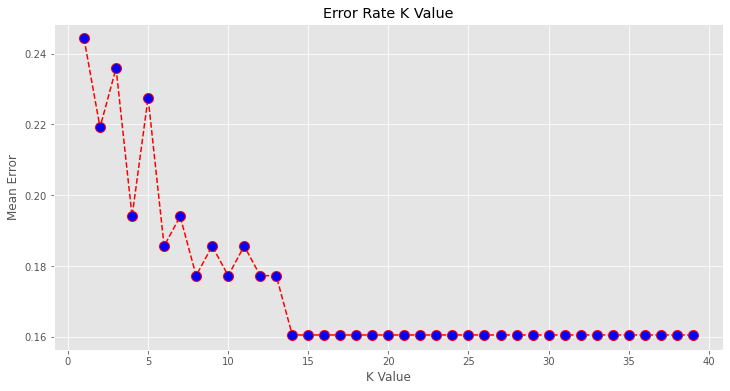

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error_rate, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

In this graphic we can see that the optimal K values would be 8,10,12,13 because for higher k, the error is so small that it is really overfitting.

**Conclusion**: With this model we have not only obtained better performance but also minimized false negatives.

## 4.3 Decision Trees

In case of Decision tree if tree is under performing, it is necessary to increase n_estimators and max_depth. If tree is over-fitting decrease both.
In general a Decision tree overfits for large max_depth because he deeper you allow the more complex your model will become.
despite incresing max_depth value training error will always go down
Using min_samples fit we can also solve overfitting

In [28]:
def run_Decision_Tree(X_train, X_test, y_train, y_test):
    
    '''This function Decision Tree model.
    In order to evaluate the model performance it uses roc-auc metric.
    It prints predictions of train and test set in order to evaluate over or underfitting and 
    it also calculates the confusion matrix and False Positive Rate (FPR) Vs False Negative Rate (FNR)
    parameters:
    n_estimators — the number of trees in the forest;
    criterion — the function used to measure the quality of a split;
    max_features — the number of features to consider when looking for the best split;
    min_samples_leaf — the minimum number of samples required to be at a leaf node;
    max_depth — the maximum depth of the tree.'''
    
    
    grid_search_dt = DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
    grid_search_dt.fit(X_train, y_train)
    

    
    print('Train set')
    pred = grid_search_dt.predict_proba(X_train)
    print('Decision Tree: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = grid_search_dt.predict_proba(X_test)
    print('Decision Tree: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, grid_search_dt.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, grid_search_dt.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 
    

    

In [29]:
results_dict_DTC = {}
shapes_dict_DTC = {}
conf_matrix_DTC = {}
FNR_dict_DTC = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_Decision_Tree(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_DTC[oversampler] = roc[0]
    conf_matrix_DTC[oversampler] = roc[1]
    FNR_dict_DTC[oversampler] = roc[3]
    shapes_dict_DTC[oversampler] = len(X_resampled)  
    print()
    
print()

random
Train set
Decision Tree: 0.8079179282006921
Test set
Decision Tree: 0.6481900452488688

smote
Train set
Decision Tree: 0.8637475670415224
Test set
Decision Tree: 0.6628959276018099

adasyn
Train set
Decision Tree: 0.8345029076269291
Test set
Decision Tree: 0.664027149321267

border1
Train set
Decision Tree: 0.8927605968858132
Test set
Decision Tree: 0.4802036199095022

border2
Train set
Decision Tree: 0.8520322335576297
Test set
Decision Tree: 0.6815610859728507

svm
Train set
Decision Tree: 0.8867390246539792
Test set
Decision Tree: 0.6504524886877828




### Summary of results

a) Summary of all roc-auc scores dependeng of sampling method

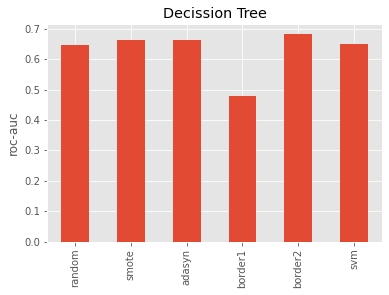

In [30]:
pd.Series(results_dict_DTC).plot.bar()
plt.title('Decission Tree')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [31]:
conf_matrix_DTC

{'random': array([[40, 28],
        [ 4,  9]], dtype=int64),
 'smote': array([[34, 34],
        [ 2, 11]], dtype=int64),
 'adasyn': array([[34, 34],
        [ 2, 11]], dtype=int64),
 'border1': array([[51, 17],
        [10,  3]], dtype=int64),
 'border2': array([[40, 28],
        [ 2, 11]], dtype=int64),
 'svm': array([[39, 29],
        [ 6,  7]], dtype=int64)}

c) False Negative Rate

In [32]:
FNR_dict_DTC

{'random': 0.3076923076923077,
 'smote': 0.15384615384615385,
 'adasyn': 0.15384615384615385,
 'border1': 0.7692307692307693,
 'border2': 0.15384615384615385,
 'svm': 0.46153846153846156}

In [33]:
{'random': 0.07692307692307693,
 'smote': 0.15384615384615385,
 'adasyn': 0.15384615384615385,
 'border1': 0.23076923076923078,
 'border2': 0.15384615384615385,
 'svm': 0.38461538461538464}

{'random': 0.07692307692307693,
 'smote': 0.15384615384615385,
 'adasyn': 0.15384615384615385,
 'border1': 0.23076923076923078,
 'border2': 0.15384615384615385,
 'svm': 0.38461538461538464}

**Conclusion**: Despite having a slightly worse performance than the KNN model but the FNR values are much smaller, for the case of oversampling smote, adasyn and boder2 and therefore this models are better.

 # 4.4 Support Vector Machine

making use of the kernel trick have a tendancy to overfit. As always, regularization parameters are handy for controlling this. The sklearn SVM methods provide C and gamma functions for this purpose.

In [34]:
def run_SVC_1(X_train, X_test, y_train, y_test):
    
    clf_svc = SVC(probability = True, random_state = 42, kernel='rbf', gamma='scale', C=2)

   
    best_clf_svc = clf_svc.fit(X_train, y_train)
    
    
    
    print('Train set')
    pred = best_clf_svc.predict_proba(X_train)
    print('SVC: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_svc.predict_proba(X_test)
    print('SVC: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_svc.predict(X_test))
    
    #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_svc.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 

    
    

In [35]:
results_dict = {}
shapes_dict = {}
conf_matrix = {}
FNR_dict = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_SVC_1(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict[oversampler] = roc[0]
    conf_matrix[oversampler] = roc[1]
    FNR_dict[oversampler] = roc[3]
    shapes_dict[oversampler] = len(X_resampled)  
    print()
    
print()

random
Train set
SVC: 0.9754271193771626
Test set
SVC: 0.6006787330316743

smote
Train set
SVC: 0.9933634299307958
Test set
SVC: 0.5701357466063348

adasyn
Train set
SVC: 0.9918362782375307
Test set
SVC: 0.5588235294117647

border1
Train set
SVC: 0.9899978373702422
Test set
SVC: 0.583710407239819

border2
Train set
SVC: 0.9895539396570436
Test set
SVC: 0.6085972850678734

svm
Train set
SVC: 0.972575151384083
Test set
SVC: 0.5599547511312217




In [36]:
FNR_dict

{'random': 0.6153846153846154,
 'smote': 0.6153846153846154,
 'adasyn': 0.6923076923076923,
 'border1': 0.6923076923076923,
 'border2': 0.6153846153846154,
 'svm': 0.6153846153846154}

### **Summary of results**

a) Summary of all roc-auc scores dependeng of sampling method

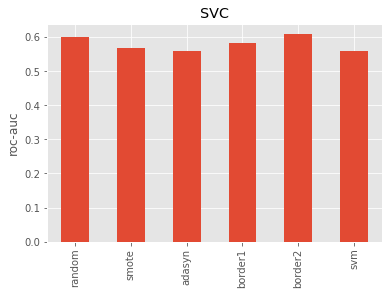

In [37]:
pd.Series(results_dict).plot.bar()
plt.title('SVC')
plt.ylabel('roc-auc')

plt.show();

b) Confusion Matrix

In [38]:
conf_matrix

{'random': array([[53, 15],
        [ 8,  5]], dtype=int64),
 'smote': array([[60,  8],
        [ 8,  5]], dtype=int64),
 'adasyn': array([[57, 11],
        [ 9,  4]], dtype=int64),
 'border1': array([[57, 11],
        [ 9,  4]], dtype=int64),
 'border2': array([[60,  8],
        [ 8,  5]], dtype=int64),
 'svm': array([[58, 10],
        [ 8,  5]], dtype=int64)}

In [39]:
FNR_dict

{'random': 0.6153846153846154,
 'smote': 0.6153846153846154,
 'adasyn': 0.6923076923076923,
 'border1': 0.6923076923076923,
 'border2': 0.6153846153846154,
 'svm': 0.6153846153846154}

Not good model becaus FNR values are high in spite of roc-auc

# 4.5 Random Forest

Since the DT model has not badly results of FNR I am going to try the Random Forest model.

In [40]:
def run_RF(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(random_state = 42)
    param_grid = {'n_estimators': [50, 100],
                  'criterion': ['entropy', 'gini'],
                  'bootstrap': [True],
                  'max_depth': [2, 3, 4,5,6,7,8,9],
                  'max_features': ['log2', 'sqrt', 0.8, 0.5],
                  'min_samples_leaf': [2, 3, 5],
                  'min_samples_split': [2, 3, 5]}
    
    clf_rf = GridSearchCV(rf, param_grid = param_grid, scoring = 'recall', cv = 5, verbose = False, n_jobs = -1)
    best_clf_rf = clf_rf.fit(X_train, y_train)
    
    print("Best: %f using %s" % (best_clf_rf.best_score_, best_clf_rf.best_params_))
    
    
    print('Train set')
    pred = best_clf_rf.predict_proba(X_train)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = best_clf_rf.predict_proba(X_test)
    print('Random Forest roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))
    
    #confusion matrix
    cf_matrix = confusion_matrix(y_test, best_clf_rf.predict(X_test))
 
     #False Positive Rate (FPR) Vs False Negative Rate (FNR)
    tn, fp, fn, tp = confusion_matrix(y_test, best_clf_rf.predict(X_test), labels=[0,1]).ravel()

    FPR = fp / (tn + fp)

    FNR = fn / (tp + fn)
    
    
    
    return roc_auc_score(y_test, pred[:, 1]), cf_matrix, FPR, FNR 


In [ ]:
results_dict_RF = {}
shapes_dict_RF = {}
conf_matrix_RF = {}
FNR_dict_RF = {}


for oversampler in oversampler_dict.keys():
    print(oversampler)
    
    #resample
    X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
    
    #evaluate performance
    roc = run_RF(X_resampled, X_test, y_resampled, y_test)
    
    
    
    #store results
    results_dict_RF[oversampler] = roc[0]
    conf_matrix_RF[oversampler] = roc[1]
    FNR_dict_RF[oversampler] = roc[3]
    shapes_dict_RF[oversampler] = len(X_resampled)  
    print()
    
print()

random


In [ ]:
FNR_dict_RF

# 5. Summary and conclusions

Despite all attempts we have not been able to solve the overfitting even by forcing the overfitting, which makes me think that it may be due to a data problem as mentioned above.

However, a summary of the best results:

Function to visualize 

In [ ]:
def plot_cm(classifier, predictions):
    cm = confusion_matrix(y_test, predictions)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap='RdBu')
    classNames = ['No Rcidiva','Recidiva']
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    plt.title("Confusion matrix")
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]), 
                     horizontalalignment='center', color='white')
    
    plt.show()
        
    tn, fp, fn, tp = cm.ravel()

    
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    F1 = 2*recall*precision/(recall+precision)
    FPR = fp / (tn + fp)
    FNR = fn / (tp + fn)

    
    print('roc_auc_test: {}'.format(roc_auc_score(y_test, pred[:,1])))
    print('Recall={0:0.3f}'.format(recall),'\nPrecision={0:0.3f}'.format(precision))
    print('F1={0:0.3f}'.format(F1))
    print('False Positive Rate={0:0.3f}'.format(FPR))
    print('False Negative Rate={0:0.3f}'.format(FNR))

### Logistic Regression: Randomsampling

In [ ]:
ros = RandomOverSampler(
        sampling_strategy='auto', #oversample de minority class
        random_state=0) #reproducibility

X_ros, y_ros = ros.fit_resample(X_train, y_train)

In [ ]:
LG = LogisticRegression(
    random_state=42,
    penalty='l1',
    C=0.1,
    max_iter=10,
    solver = 'saga')
    
LG.fit(X_ros, y_ros)
pred = model.predict_proba(X_test)


In [ ]:
plot_cm(LG, model.predict(X_test))

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

### KNN: border1sampling

In [ ]:
border1 = BorderlineSMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=3,
    m_neighbors=5,
    kind='borderline-1',
    n_jobs=4)

X_border1, y_border1 = border1.fit_resample(X_train, y_train)

In [ ]:
KNN = KNeighborsClassifier(n_neighbors=7, p=1, metric='minkowski' ) 
 
KNN.fit(X_border1, y_border1)
pred = KNN.predict_proba(X_test)   


In [ ]:
plot_cm(KNN, KNN.predict(X_test))

### Decision Tree : adasyn - border2

a) Adasyn

In [ ]:
ads= ADASYN(
    sampling_strategy='auto',
    random_state=0,
    n_neighbors=3,
    n_jobs=-1)
X_ads, y_ads = ads.fit_resample(X_train, y_train)

In [ ]:
DT_ads= DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
DT_ads.fit(X_ads, y_ads)
pred = DT_ads.predict_proba(X_test)

In [ ]:
plot_cm(DT_ads, DT_ads.predict(X_test))

b) border2

In [ ]:
border2=  BorderlineSMOTE(
    sampling_strategy='auto',
    random_state=0,
    k_neighbors=3,
    m_neighbors=5,
    kind='borderline-2',
    n_jobs=-1)
X_border2, y_border2 = border2.fit_resample(X_train, y_train)

In [ ]:
DT_border2= DecisionTreeClassifier(criterion='entropy',max_depth=4, random_state=42, splitter='random' )
 
DT_border2.fit(X_border2, y_border2)
pred = DT_border2.predict_proba(X_test)

In [ ]:
plot_cm(DT_border2, DT_border2.predict(X_test))

It is better with the border2 technique because despite having the same FNR value, it has a lower FPR value.

The results for the SVM and Random Forest models are so bad that I will not consider them.